# Example with tidal flume

In this simulation that seems to mimic a lab experiment, there is a long channel with one tidally forced boundary
on the left. At inflow on the left boundary salt sea-water will intrude into the channel. The channel is 130m
long, 1m wide and 20 cm deep. The "tide" on the left bounday has a period of 10 minutes and an amplitude of 0.75 cm. The inflowing water has a salinity of 12.5 psu. The net inflow on the right boundary is 0.005 m^3/s.
The simulation starts at rest with fresh water in the entire basin and finishes after 100 minutes, equaling 10 cycles.


In [1]:
# Load required libraries
using Pkg
Pkg.precompile() # command needed after modifying the src code
Pkg.activate("..")
using Particles
using Plots
using Random
using ZipFile

randpool = MersenneTwister(0) #Generate same random numbers every time

nothing

Precompiling project...


  ✓ 

Particles
  1 dependency successfully precompiled in 44 seconds. 249 already precompiled.
  Activating project at `j:\Master_Thesis\particles.jl`

In [2]:
# unzip the flow data (if not already done)

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

if !isdir("./data/tidal_flume_map.zarr") 
    unzip("./data/tidal_flume_map.zip","./data")
end


In [128]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults

# settings for this experiment
n = 20000 # number of particles
d["nparticles"] = n
# problem specific settings
x_min_release = 10. # release particles in this znode
d["x_min_release"] = x_min_release
x_max_release = 10.
d["x_max_release"] = x_max_release
z_min_release = -0.2  
d["z_min_release"] = z_min_release
z_max_release = -0.003
d["z_max_release"] = z_max_release
y_release = 1.0
d["y_release"] = y_release 

# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = x_min_release .+ (x_max_release - x_min_release) .* rand(randpool, n, 1) # x
p[2, :] .= y_release # y
p[3, :] = z_min_release .+ (z_max_release - z_min_release) .* rand(randpool, n, 1) # z
p[4, :] .= 0.0 # age
d["particles"] = p # initial values
# simulation time
d["dt"] = 10.0     #time-step
d["tstart"] = 1200 #start after 2 cycles
d["tend"]   = 2400.0 #3600.0
tstart=d["tstart"] 
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(0.0:30.0:tend)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_tidal_flume.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:30.0:tend)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(tstart:30.0:tend)

d #show configuration

Dict{String, Any} with 29 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => [10.0 10.0 … 10.0 10.0; 1.0 1.0 … 1.0 1.0; -0.09449…
  "nparticles"           => 20000
  "plot_maps_times"      => [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0,…
  "dt"                   => 10.0
  "tend"                 => 2400.0
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_tidal_flume.nc"
  "z_min_release"        => -0.2
  "variables"            => ["x", "y", "z", "age"]
  "x_min_release"        => 10.0
  "keep_particle_times"  => [1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 13…
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "z_max_release"        => -0.003
  "plot_maps_func"       => plot_maps_xz
  ⋮                      => ⋮

Two test cases are embedded.
The first test case tests the algorithm that divides the timestep by half, takes a new random number and thus weakens the strength of diffusion strength and "controlls" the direction of turbulent velocity. To test the algorithm, we only add one particle into the computation domain and set the keyword parameter `d["if_cross_bc"] = false` and `d["if_apply_cross_bc_test"] = true`.

In [129]:
# the following options are to be added in the default_userdata() function
# if to apply the algorithm to prevent the algorithm from crossing the boundary or not
d["is_cross_bc"] = false # if added, the algorithm will terminate once the particle is out of the boundary
d["is_apply_cross_bc_test"] = false # if applied, only one particle is used and all virtual trajectories are also recorded
if d["is_apply_cross_bc_test"]
    d["the_virtual_trajectory"] = d["particles"]
end
# to be added according to the actual problem
d["is_particle_in_domain"] = x -> nothing
d["is_keep_these_particles"] = trues(d["nparticles"],) # check if particles move out of the is_particle_in_domain
d["recursion_depth"] = 10

#
d["nparticles_bound"] = 20

# Randompool setup and restart
randpool = MersenneTwister(123) #Generate same random numbers every time
d["rng"] = randpool


MersenneTwister(123)

In [130]:
# Load flow data and create interpolators

Zarr_data = ZarrData("./data","tidal_flume_map.zarr")
t0=get_reftime(Zarr_data)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
function v(x,y,z,t) # interpolation of v is implemented but gives no useful addition to the zeros below
    return 0.0
end
function w(x,y,z,t) #TODO make interpolation of w work
    return 0.0
end
s=initialize_interpolation(Zarr_data,"salinity",t0)
d["smap"] = s

nothing

In [131]:
# create an animation of the flow field
x_left = 9.0
x_right = 130.0
y_middle = 1.0
z_surface = -0.003

z_bottom = -0.2
t_start=1200.0 #Skip first 20 minutes -= 2 cycles
t_step=60.0 # 6s in file, here coarser
t_stop=3600.0 #max 100minutes=6000s with steps 6s / period is 600s
"""
#grid for plotting arrows
xgrid=collect(range(x_left,x_right,length=20))
zgrid=collect(range(z_bottom,z_surface,length=10))
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

anim = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
    # grid for plotting only
    x_points = range(x_left,stop=x_right,length=130)
    z_points = range(z_bottom,stop=z_surface,length=100)
    #u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
    s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
    h_interp = [h(x,y_middle,0.0,t) for x in x_points] # water level

    #l = @layout([a; b])
    #p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity time=\$(t)",clims=(-0.5,0.5))
    p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity after \$(t/600.0) cycles",clims=(0,15),color=:dense)
    quiver!(p2,vec(xs),vec(zs),quiver=(u.(vec(xs),y_middle,vec(zs),t),w.(vec(xs),y_middle,vec(zs),t)), arrowscale=0.6, headsize=0.1)
    #plot(p1,p2,layout=l,size=(800,300))
    plot!(p2,x_points,h_interp,label=false,linewidth=2,color=:black)
    plot(p2,size=(800,300))
end

gif(anim, "./tidal_flume.gif", fps = 4)
"""
nothing

Core.nothing

In [132]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes as ds the function f in the equation ds=f(s,t)dt+g(s,t)dw 
for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = u(x, y, z, t)
   # dy/dt=v
    ∂s.y = v(x, y, z, t)
   # dz/dt=0
    ∂s.z = w(x, y, z, t)
   # age=(t-t0)
    ∂s.t = 1.0
end
d["f"] = f!

#
# TODO: add function g! to simulate diffusion to simulation routine
#

"""
   !g(ds,s,t,i,d)

   Dynamic model, computes as ds the function g in the equation ds=f(s,t)dt+g(s,t)dw 
   for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function g!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = 0.0
   # dy/dt=v
    ∂s.y = 0.0
   # dz/dt=0
    ∂s.z = 0.0
   # age=(t-t0)
    ∂s.t = 0.0
end
d["g"] = g!

g! (generic function with 1 method)

In [133]:
# compulsory input             
function is_particle_in_domain(p)
    x,y,z,t = p
    is_inside_xdir = x_left ≤ x ≤ x_right
    is_inside_ydir = true
    is_inside_zdir = z_bottom ≤ z ≤ h(x,y_middle,z,t)
    return is_inside_xdir && is_inside_zdir 
end
d["is_particle_in_domain"] = is_particle_in_domain

is_particle_in_domain (generic function with 1 method)

In [134]:
function approximate_concentration(x_points, z_points, particles, isactivelist)
    # return concentration field defined in specified cell centers
    active_particles_indexes = findall(isactivelist)
    concentration_field = zeros(length(z_points)-1, length(x_points)-1)
    for i in active_particles_indexes
        if is_particle_in_domain(particles[:, i])
            x, _, z, t = particles[:,i]
            box_xindex = findfirst(var->x<var, x_points) 
            box_zindex = findfirst(var->z<var, z_points) 
            if !isnothing(box_xindex) 
                concentration_field[box_zindex-1, box_xindex-1] += 1
            end
        end
    end
    return concentration_field
end

approximate_concentration (generic function with 1 method)

In [135]:
# compulsory input
# add particles into the domain 
# the particles are only released at integer numbers of time instant
d["x_left"] = 9.
d["dx"] = 2
d["xc_left"] = d["x_left"] + d["dx"]/2

d["nparticles_bound"] = 2000000
d["particles"] = zeros(length(variables), d["nparticles_bound"])
d["is_particles_active"] = falses(d["nparticles_bound"],)
d["is_keep_these_particles"] = trues(d["nparticles_bound"],)

x_bccell =[d["x_left"], d["x_left"]+2]
z_points = range(z_bottom, z_surface, length=21) 

function release_particles(d, p, t)
    get_release(t) = true # check if release particles at this instant
    is_release_now = get_release(t)
    if is_release_now
        # check current concentration
        c_real = approximate_concentration(x_bccell, z_points, p, d["is_particles_active"])
        # check expected concentration
        zc_points = (z_points[1:end-1] + z_points[2:end])/2
        c_force = [s(d["xc_left"], y_middle, z, t) for z in zc_points] .*10 # 1 unit salinity (computed by per unit area) is represented by 10 particles
        # release particles accordingly
        is_release_this_cell = c_force .> c_real
        last_active_index = count(d["is_particles_active"]) 
        for i in 1:length(is_release_this_cell)
            if is_release_this_cell[i]
                npart_release = ceil(Int, c_force[i] - c_real[i])
                indices = (last_active_index+1: last_active_index+npart_release)
                d["is_particles_active"][indices] .= true
                p[1,indices] = d["x_left"] .+ d["dx"]*rand(randpool, npart_release,1)
                p[2,indices] .= y_middle 
                p[3,indices] = z_points[i] .+ (z_points[i+1]-z_points[i])*rand(randpool, npart_release,1)
                p[4,indices] .= 0
                last_active_index += npart_release
            end
        end
    end
    return p,last_active_index
end
d["release_particles"] = release_particles

release_particles (generic function with 1 method)

In [136]:
#run the actual particle model

@time run_simulation(d)

writing output to memory at t = [1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0  …  2130.0, 2160.0, 2190.0, 2220.0, 2250.0, 2280.0, 2310.0, 2340.0, 2370.0, 2400.0]
interrupt simulation for output at t = [1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0  …  2130.0, 2160.0, 2190.0, 2220.0, 2250.0, 2280.0, 2310.0, 2340.0, 2370.0, 2400.0]
Simulation from time 1200s to 2400.0s since 2000-01-01T00:00:00
t=1200 -> 1200.0  : 2000-01-01T00:20:00 -> 2000-01-01T00:20:00 : 0.0%
The number of particle is 0.
simulate! runs for once.
t=1200 -> 1230.0  : 2000-01-01T00:20:00 -> 2000-01-01T00:20:30 : 2.5%
The number of particle is 0.


simulate! runs for once.


t=1230.0 -> 1260.0  : 2000-01-01T00:20:30 -> 2000-01-01T00:21:00 : 5.0%
The number of particle is 2625.


simulate! runs for once.
t=1260.0 -> 1290.0  : 2000-01-01T00:21:00 -> 2000-01-01T00:21:30 : 7.5%
The number of particle is 6478.


simulate! runs for once.
t=1290.0 -> 1320.0  : 2000-01-01T00:21:30 -> 2000-01-01T00:22:00 : 10.0%


The number of particle is 12280.
simulate! runs for once.
t=1320.0 -> 1350.0  : 2000-01-01T00:22:00 -> 2000-01-01T00:22:30 : 12.5%
The number of particle is 19606.


simulate! runs for once.
t=1350.0 -> 1380.0  : 2000-01-01T00:22:30 -> 2000-01-01T00:23:00 : 15.0%
The number of particle is 27050.


simulate! runs for once.
t=1380.0 -> 1410.0  : 2000-01-01T00:23:00 -> 2000-01-01T00:23:30 : 17.5%
The number of particle is 34344.


simulate! runs for once.
t=1410.0 -> 1440.0  : 2000-01-01T00:23:30 -> 2000-01-01T00:24:00 : 20.0%
The number of particle is 40296.


simulate! runs for once.
t=1440.0 -> 1470.0  : 2000-01-01T00:24:00 -> 2000-01-01T00:24:30 : 22.5%
The number of particle is 43193.


simulate! runs for once.
t=1470.0 -> 1500.0  : 2000-01-01T00:24:30 -> 2000-01-01T00:25:00 : 25.0%
The number of particle is 43193.


simulate! runs for once.
t=1500.0 -> 1530.0  : 2000-01-01T00:25:00 -> 2000-01-01T00:25:30 : 27.5%
The number of particle is 43288.


simulate! runs for once.
t=1530.0 -> 1560.0  : 2000-01-01T00:25:30 -> 2000-01-01T00:26:00 : 30.0%
The number of particle is 44123.


simulate! runs for once.
t=1560.0 -> 1590.0  : 2000-01-01T00:26:00 -> 2000-01-01T00:26:30 : 32.5%
The number of particle is 46060.


simulate! runs for once.
t=1590.0 -> 1620.0  : 2000-01-01T00:26:30 -> 2000-01-01T00:27:00 : 35.0%
The number of particle is 47124.


simulate! runs for once.
t=1620.0 -> 1650.0  : 2000-01-01T00:27:00 -> 2000-01-01T00:27:30 : 37.5%
The number of particle is 47825.


simulate! runs for once.
t=1650.0 -> 1680.0  : 2000-01-01T00:27:30 -> 2000-01-01T00:28:00 : 40.0%
The number of particle is 48645.


simulate! runs for once.
t=1680.0 -> 1710.0  : 2000-01-01T00:28:00 -> 2000-01-01T00:28:30 : 42.5%
The number of particle is 49711.


simulate! runs for once.
t=1710.0 -> 1740.0  : 2000-01-01T00:28:30 -> 2000-01-01T00:29:00 : 45.0%
The number of particle is 50700.


simulate! runs for once.
t=1740.0 -> 1770.0  : 2000-01-01T00:29:00 -> 2000-01-01T00:29:30 : 47.5%
The number of particle is 51109.


simulate! runs for once.
t=1770.0 -> 1800.0  : 2000-01-01T00:29:30 -> 2000-01-01T00:30:00 : 50.0%
The number of particle is 51975.


simulate! runs for once.


t=1800.0 -> 1830.0  : 2000-01-01T00:30:00 -> 2000-01-01T00:30:30 : 52.5%
The number of particle is 54117.


simulate! runs for once.
t=1830.0 -> 1860.0  : 2000-01-01T00:30:30 -> 2000-01-01T00:31:00 : 55.0%
The number of particle is 57902.


simulate! runs for once.
t=1860.0 -> 1890.0  : 2000-01-01T00:31:00 -> 2000-01-01T00:31:30 : 57.5%
The number of particle is 63212.


simulate! runs for once.
t=1890.0 -> 1920.0  : 2000-01-01T00:31:30 -> 2000-01-01T00:32:00 : 60.0%
The number of particle is 69963.


simulate! runs for once.
t=1920.0 -> 1950.0  : 2000-01-01T00:32:00 -> 2000-01-01T00:32:30 : 62.5%
The number of particle is 77370.


simulate! runs for once.
t=1950.0 -> 1980.0  : 2000-01-01T00:32:30 -> 2000-01-01T00:33:00 : 65.0%
The number of particle is 84667.


simulate! runs for once.
t=1980.0 -> 2010.0  : 2000-01-01T00:33:00 -> 2000-01-01T00:33:30 : 67.5%
The number of particle is 91172.


simulate! runs for once.
t=2010.0 -> 2040.0  : 2000-01-01T00:33:30 -> 2000-01-01T00:34:00 : 70.0%
The number of particle is 95797.


simulate! runs for once.
t=2040.0 -> 2070.0  : 2000-01-01T00:34:00 -> 2000-01-01T00:34:30 : 72.5%
The number of particle is 96968.


simulate! runs for once.
t=2070.0 -> 2100.0  : 2000-01-01T00:34:30 -> 2000-01-01T00:35:00 : 75.0%
The number of particle is 96968.


simulate! runs for once.
t=2100.0 -> 2130.0  : 2000-01-01T00:35:00 -> 2000-01-01T00:35:30 : 77.5%
The number of particle is 97040.


simulate! runs for once.
t=2130.0 -> 2160.0  : 2000-01-01T00:35:30 -> 2000-01-01T00:36:00 : 80.0%
The number of particle is 97535.


simulate! runs for once.
t=2160.0 -> 2190.0  : 2000-01-01T00:36:00 -> 2000-01-01T00:36:30 : 82.5%
The number of particle is 99595.


simulate! runs for once.
t=2190.0 -> 2220.0  : 2000-01-01T00:36:30 -> 2000-01-01T00:37:00 : 85.0%
The number of particle is 100859.


simulate! runs for once.
t=2220.0 -> 2250.0  : 2000-01-01T00:37:00 -> 2000-01-01T00:37:30 : 87.5%
The number of particle is 101514.


simulate! runs for once.
t=2250.0 -> 2280.0  : 2000-01-01T00:37:30 -> 2000-01-01T00:38:00 : 90.0%
The number of particle is 102003.


simulate! runs for once.
t=2280.0 -> 2310.0  : 2000-01-01T00:38:00 -> 2000-01-01T00:38:30 : 92.5%
The number of particle is 102367.


simulate! runs for once.
t=2310.0 -> 2340.0  : 2000-01-01T00:38:30 -> 2000-01-01T00:39:00 : 95.0%
The number of particle is 102819.


simulate! runs for once.
t=2340.0 -> 2370.0  : 2000-01-01T00:39:00 -> 2000-01-01T00:39:30 : 97.5%
The number of particle is 103217.


simulate! runs for once.
t=2370.0 -> 2400.0  : 2000-01-01T00:39:30 -> 2000-01-01T00:40:00 : 100.0%
The number of particle is 104084.


simulate! runs for once.
542.362401 seconds (1.62 G allocations: 83.636 GiB, 2.70% gc time, 0.18% compilation time)


In [137]:
# #grid for plotting arrows
# xgrid=collect(range(x_left,x_right,length=20))
# zgrid=collect(range(z_bottom,z_surface,length=10))
# nx=length(xgrid)
# nz=length(zgrid)
# xs=repeat(xgrid,1,nz)
# zs=repeat(zgrid,1,nx)'

# anim = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
#     # grid for plotting only
#     x_points = range(x_left,stop=x_right,length=130)
#     z_points = range(z_bottom,stop=z_surface,length=100)
#     #u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
#     s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
#     h_interp = [h(x,y_middle,0.0,t) for x in x_points] # water level

#     l = @layout([a ; b])
#     p1=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity after $(t/600.0) cycles",clims=(0,15),color=:dense,legend=false)
#     plot!(p1,x_points,h_interp,label=false,linewidth=2,color=:black)
#     # add particles
#     itime=findmin(abs.(t.-d["keep_particle_times"]))[2]
#     age=d["all_particles"][itime][4,:]./600.0 # in cycles
#     #println("time=$(t/600.0) cycles, age=$(sum(age)/length(age))")
#     p2=scatter(d["all_particles"][itime][1,:],d["all_particles"][itime][3,:],zcolor=age,clims=(0,3.0),xlims=(x_left,x_right),ylims=(z_bottom,z_surface))
#     plot(p1,p2,size=(1200,500),layout=l)
# end

#gif(anim, fps = 4)
#gif(anim, "./tidal_flume.gif", fps = 4)

In [138]:
# create an animation of the flow field
t_points = range(t_start, stop = t_stop-t_step, step = t_step)
z_points = range(z_bottom,stop=z_surface,length=100)

#for xcor in range(20, 60, step=10)
#    anim_upf = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
#        plot([u(xcor,y_middle,z,t) for z in z_points], z_points, xlabel="velocity u",ylabel="position z ",title="uvel at x=$(xcor) t=$(t)s", xlim=(-0.4,0.3), left_margin = 5Plots.mm, bottom_margin = 15Plots.mm, right_margin = 5Plots.mm, top_margin = 15Plots.mm, size=(600,600))
#    end

#    gif(anim_upf, "./result/uvel_x=$(xcor).gif", fps = 20)
#end

nothing


┌ Info: Saved animation to j:\Master_Thesis\particles.jl\case_tidal_flume\result\sapprox_dt=10.0.gif
└ @ Plots C:\Users\hugo1111234\.julia\packages\Plots\3BCH5\src\animation.jl:156


Plots.AnimatedGif("j:\\Master_Thesis\\particles.jl\\case_tidal_flume\\result\\sapprox_dt=10.0.gif")
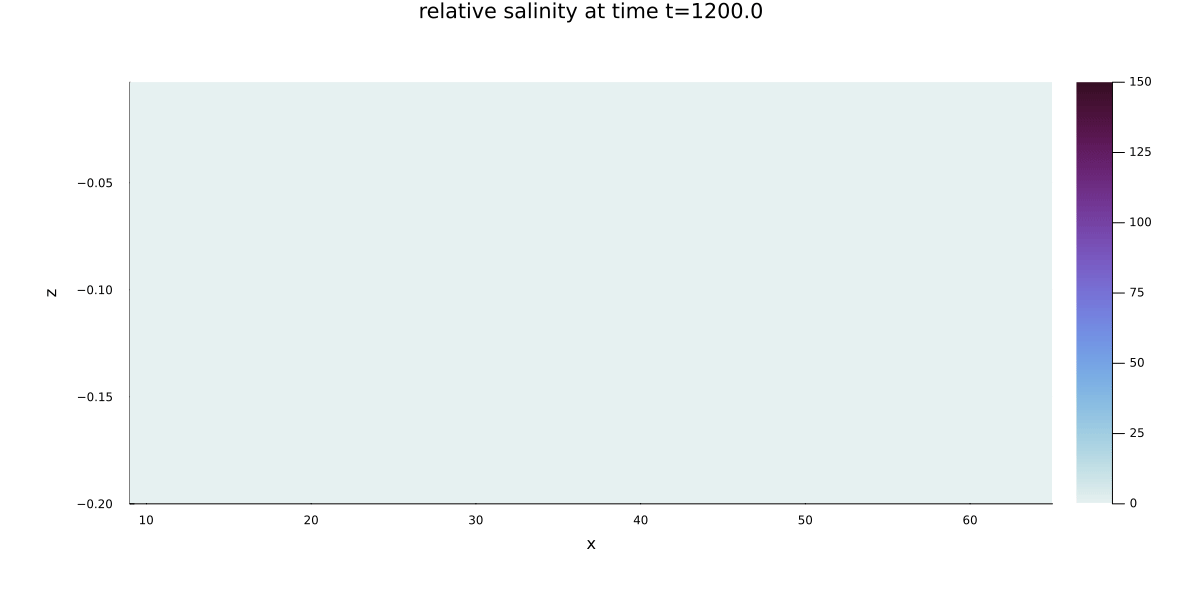

In [139]:
# create an animation of the flow field
x_left = d["x_left"]
x_mid = 65
x_right = 130.0
y_middle = 1.0
z_surface = -0.003

z_bottom = -0.2
t_start=1200.0 #Skip first 30 minutes = 3 cycles
t_step=60.0 # 6s in file, here coarser
t_stop=2400 #max 100minutes=6000s with steps 6s / period is 600s

t_points = range(t_start, stop = t_stop-t_step, step = t_step)
z_points = range(z_bottom,stop=z_surface,length=40)
x_points = range(x_left, x_mid, step=2)
zc_points = (z_points[1:end-1] + z_points[2:end]) ./2
xc_points = (x_points[1:end-1] + x_points[2:end]) ./2

concentration_field = zeros(length(z_points)-1, length(x_points)-1)

function is_particle_in_domain(p_itime)
    x,_,z, _ = p_itime 
    return (x_left<x<x_right) && (z_bottom<z<z_surface)

end

function approximate_concentration(x_points, z_points, particles, isactivelist)
    # return concentration field defined in specified cell centers
    active_particles_indexes = findall(isactivelist)
    concentration_field = zeros(length(z_points)-1, length(x_points)-1)
    for i in active_particles_indexes
        if is_particle_in_domain(particles[:, i])
            x, _, z, t = particles[:,i]
            box_xindex = findfirst(var->x<var, x_points) 
            box_zindex = findfirst(var->z<var, z_points) 
            if !isnothing(box_xindex) 
                concentration_field[box_zindex-1, box_xindex-1] += 1
            end
        end
    end
    return concentration_field
end

p8 = plot()

anim_sapprox = @animate for t in t_points
    itime=findmin(abs.(t.-d["keep_particle_times"]))[2]
    particles_itime = d["all_particles"][itime]
    isactivelist = d["is_particles_active"]
    sc_approx = approximate_concentration(x_points, z_points, particles_itime, isactivelist)
    heatmap!(xc_points, zc_points, sc_approx, xlabel="x", ylabel="z", title="relative salinity at time t=$t", color=:dense, clim=(0,150),legend=false, left_margin = 15Plots.mm, bottom_margin = 15Plots.mm, right_margin = 5Plots.mm, top_margin = 15Plots.mm, size=(1200,600))
end
gif(anim_sapprox, "./result/sapprox_dt=$(d["dt"]).gif", fps=1)

In [ ]:
# create an animation of the flow field
x_left = 1.0
x_right = 130.0
y_middle = 1.0
z_surface = -0.003

z_bottom = -0.2
t_start=1200.0 #Skip first 30 minutes = 3 cycles
t_step=60.0 # 6s in file, here coarser
t_stop=2400.0 #max 100minutes=6000s with steps 6s / period is 600s

u_interp_map = zeros(4,1)
t_points = range(t_start, stop = t_stop-t_step, step = t_step)
z_points = range(z_bottom,stop=z_surface,length=100)
y_points = range(0,2, length=21)
xcor = 65

anim_uheatmap = @animate for t in t_points
    f = plot()
    u_interp_map = [u(xcor,y,z,t) for z in z_points, y in y_points]
    heatmap!(f, y_points, z_points, u_interp_map,xlabel="y",zlabel="z",title="x-velocity at t=$(t)s",clims=(-2,2),color=:dense,legend=false)
    plot(f, size=(1000,400), left_margin = 5Plots.mm, bottom_margin = 15Plots.mm, right_margin = 15Plots.mm, top_margin = 15Plots.mm)
end
gif(anim_uheatmap, ".\\result\\uvel_heatmap_x=$(xcor).gif", fps=4)


3×4 Matrix{Int64}:
 2  3  4  5
 3  4  5  6
 4  5  6  7

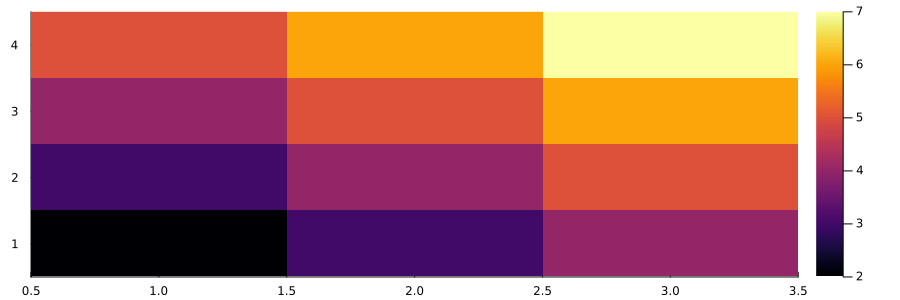

In [141]:
#a = [[i+j for i in range(1,3)] for j in range(1,4)]
a = [i+j for i in range(1,3), j in range(1,4)]
display(a)
rowlen, collen = size(a)
p4 = heatmap(range(1, rowlen), range(1, collen), a')

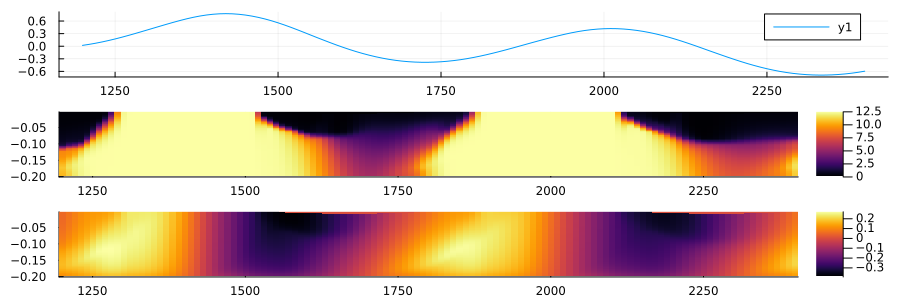

In [142]:
N_zgrid = 101
Δz = (z_surface - z_bottom) / N_zgrid
t_points = range(start=1200.0, stop=2400.0, step = 10.0)
z_points = range(z_bottom,stop=z_surface,length=N_zgrid)
V_rate = similar(t_points)
u_prof = zeros(length(z_points), length(t_points))
s_prof = zeros(length(z_points), length(t_points))
xcor = 10

for i in 1:length(t_points)
    t = t_points[i]
    u_prof_ti = [u(xcor,y_middle,z,t) for z in z_points]
    u_prof[:, i] = u_prof_ti
    s_prof[:, i] = [s(xcor,y_middle,z,t) for z in z_points] 
    V_rate[i] =  sum(u_prof)*Δz
end
p1 = plot(t_points, V_rate)
p2 = heatmap(t_points, z_points, s_prof)
p3 = heatmap(t_points, z_points, u_prof)
l = @layout([a; b; c])
plot(p1,p2,p3, layout=l)



In [148]:
count(d["is_particles_active"])

106075

In [149]:
count(d["is_particles_active"] .&& d["is_keep_these_particles"])

6219